# Analysis for Figure2c

In [1]:
1

1

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["font.family"] = "DeJavu Serif"
plt.rcParams["font.serif"] = ["Times New Roman"]

In [9]:
import copy
import gc
import os
import sys
import warnings
import importlib
from pathlib import Path

import anndata as ad
import cupy as cp
import networkx as nx
import numpy as np
import pandas as pd
import rapids_singlecell as rsc
import scanpy as sc
import scib
import scib_metrics
import scipy.stats
import statsmodels.api as sm
import torch
from sklearn.neighbors import kneighbors_graph
from statsmodels.formula.api import ols

sys.path.append("/home/icb/kemal.inecik/work/codes/tardis")
import tardis

tardis.config = tardis.config_server

sc.settings.verbosity = 3

print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: True


In [4]:
modelname = 'unavilable'
dataset_handles = {
    "Kanemaru": {"scvi_name": 'kanemaru', "tardis_name": modelname, "targets": ["sex", "age", "integration_biological_unit"]}, 
    "Braun": {"scvi_name": 'braun', "tardis_name": modelname, "targets": ["sex", "age"]}, 
    # "Suo": {"scvi_name": 'suo', "tardis_name": modelname, "targets": ["sex", "age", "organ", "integration_library_platform_coarse"]}, 
    "Miller": {"scvi_name": 'miller', "tardis_name": modelname, "targets": ["sex", "age"]}, 
    "He": {"scvi_name": 'he', "tardis_name": modelname, "targets": ["sex", "age"]}, 
    "Garcia": {"scvi_name": 'garcia', "tardis_name": modelname, "targets": ["sex", "age", "integration_sample_status"]}
}

In [5]:
updated_obs = pd.read_csv(
    os.path.join(
        "/lustre/groups/ml01/workspace/kemal.inecik/hdca/data", "metadata", "combined_with_hierarchy", "anno_V1.csv"
    ),
    index_col="Unnamed: 0",
)
new_cols = ["LVL3", "LVL2", "LVL1", "LVL0"]

for i in dataset_handles:
    dataset_handles[i]["adata"] = ad.read_h5ad(
        os.path.join(tardis.config.io_directories["processed"], f"dataset_complete_{i}.h5ad")
    )
    dataset_handles[i]["adata"].obs = pd.concat([dataset_handles[i]["adata"].obs.copy(), updated_obs.copy().loc[dataset_handles[i]["adata"].obs.index][new_cols]], axis=1)
    gc.collect()

/tmp/ipykernel_3534806/122414968.py:1: DtypeWarning: Columns (3,7,8,9,11,17,18,20,22,23,27,28,30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  updated_obs = pd.read_csv(


In [7]:
!ls -lh /lustre/groups/ml01/workspace/kemal.inecik/tardis_data/models

total 60K
drwxr-xr-x. 2 kemal.inecik OG-ICB-User 4.0K Apr 23 14:18 braun
drwxr-xr-x. 2 kemal.inecik OG-ICB-User 4.0K Apr 23 12:46 braun_sex_age
drwxr-xr-x. 2 kemal.inecik OG-ICB-User 4.0K Apr 23 14:00 garcia
drwxr-xr-x. 2 kemal.inecik OG-ICB-User 4.0K Apr 23 13:48 he
drwxr-xr-x. 2 kemal.inecik OG-ICB-User 4.0K Apr 23 15:09 he_sex_age
drwxr-xr-x. 2 kemal.inecik OG-ICB-User 4.0K Apr 23 13:48 kanemaru
drwxr-xr-x. 2 kemal.inecik OG-ICB-User 4.0K Apr 23 13:51 miller
drwxr-xr-x. 2 kemal.inecik OG-ICB-User 4.0K Apr 23 14:03 miller_sex_age
drwxr-xr-x. 2 kemal.inecik OG-ICB-User 4.0K Apr 22 21:46 run10
drwxr-xr-x. 2 kemal.inecik OG-ICB-User 4.0K Apr 23 00:10 run11
drwxr-xr-x. 2 kemal.inecik OG-ICB-User 4.0K Apr 18 14:07 run6.1_dataset_subset_age_4
drwxr-xr-x. 2 kemal.inecik OG-ICB-User 4.0K Apr 18 13:20 run6.2_dataset_subset_age_4
drwxr-xr-x. 2 kemal.inecik OG-ICB-User 4.0K Apr 18 15:36 run6.3_dataset_subset_age_4
drwxr-xr-x. 2 kemal.inecik OG-ICB-User 4.0K Apr 18 03:44 run6.4_dataset_subset_ag

In [13]:
batch_size = 512

for k, v in dataset_handles.items():

    # TODO: cannot load two models without reloading: write a sub job that pickles out latent etc, and read here then,
    print(k)
    print("calculate metrics")

    dir_path = os.path.join(tardis.config.io_directories["models"], v["scvi_name"])
    vae = tardis.MyModel.load(dir_path=dir_path, adata=v["adata"])
    vae.to_device("cpu")

    # dataset_handles[k]["scvi_r2"] = {
    #     # "reconstruction_error": vae.get_reconstruction_error(batch_size=batch_size)["reconstruction_loss"],
    #     # "elbo": vae.get_elbo(batch_size=batch_size).item(),
    #     "r2_train": vae.get_reconstruction_r2(batch_size=batch_size, indices=vae.train_indices),
    #     "r2_train_deg_20": vae.get_reconstruction_r2(
    #         top_n_differentially_expressed_genes=20, batch_size=batch_size, indices=vae.train_indices
    #     ),
    #     "r2_train_deg_50": vae.get_reconstruction_r2(
    #         top_n_differentially_expressed_genes=50, batch_size=batch_size, indices=vae.train_indices
    #     ),
    #     "r2_validation": vae.get_reconstruction_r2(batch_size=batch_size, indices=vae.validation_indices),
    #     "r2_validation_deg_20": vae.get_reconstruction_r2(
    #         top_n_differentially_expressed_genes=20, batch_size=batch_size, indices=vae.validation_indices
    #     ),
    #     "r2_validation_deg_50": vae.get_reconstruction_r2(
    #         top_n_differentially_expressed_genes=50, batch_size=batch_size, indices=vae.validation_indices
    #     ),
    # }

    # print("get_latent, calculate graph")
    # latent = ad.AnnData(X=vae.get_latent_representation(), obs=dataset_handles[i]["adata"].obs.copy())
    # rsc.utils.anndata_to_GPU(latent)
    # rsc.pp.neighbors(adata=latent, n_neighbors=50)
    # rsc.tl.umap(adata=latent)
    # rsc.utils.anndata_to_CPU(latent)
    # dataset_handles[k]["scvi_latent"] = latent.copy()

    del vae#, latent
    gc.collect()
    cp.get_default_memory_pool().free_all_blocks()
    cp.get_default_pinned_memory_pool().free_all_blocks()
    gc.collect()

NameError: name 'tardis' is not defined

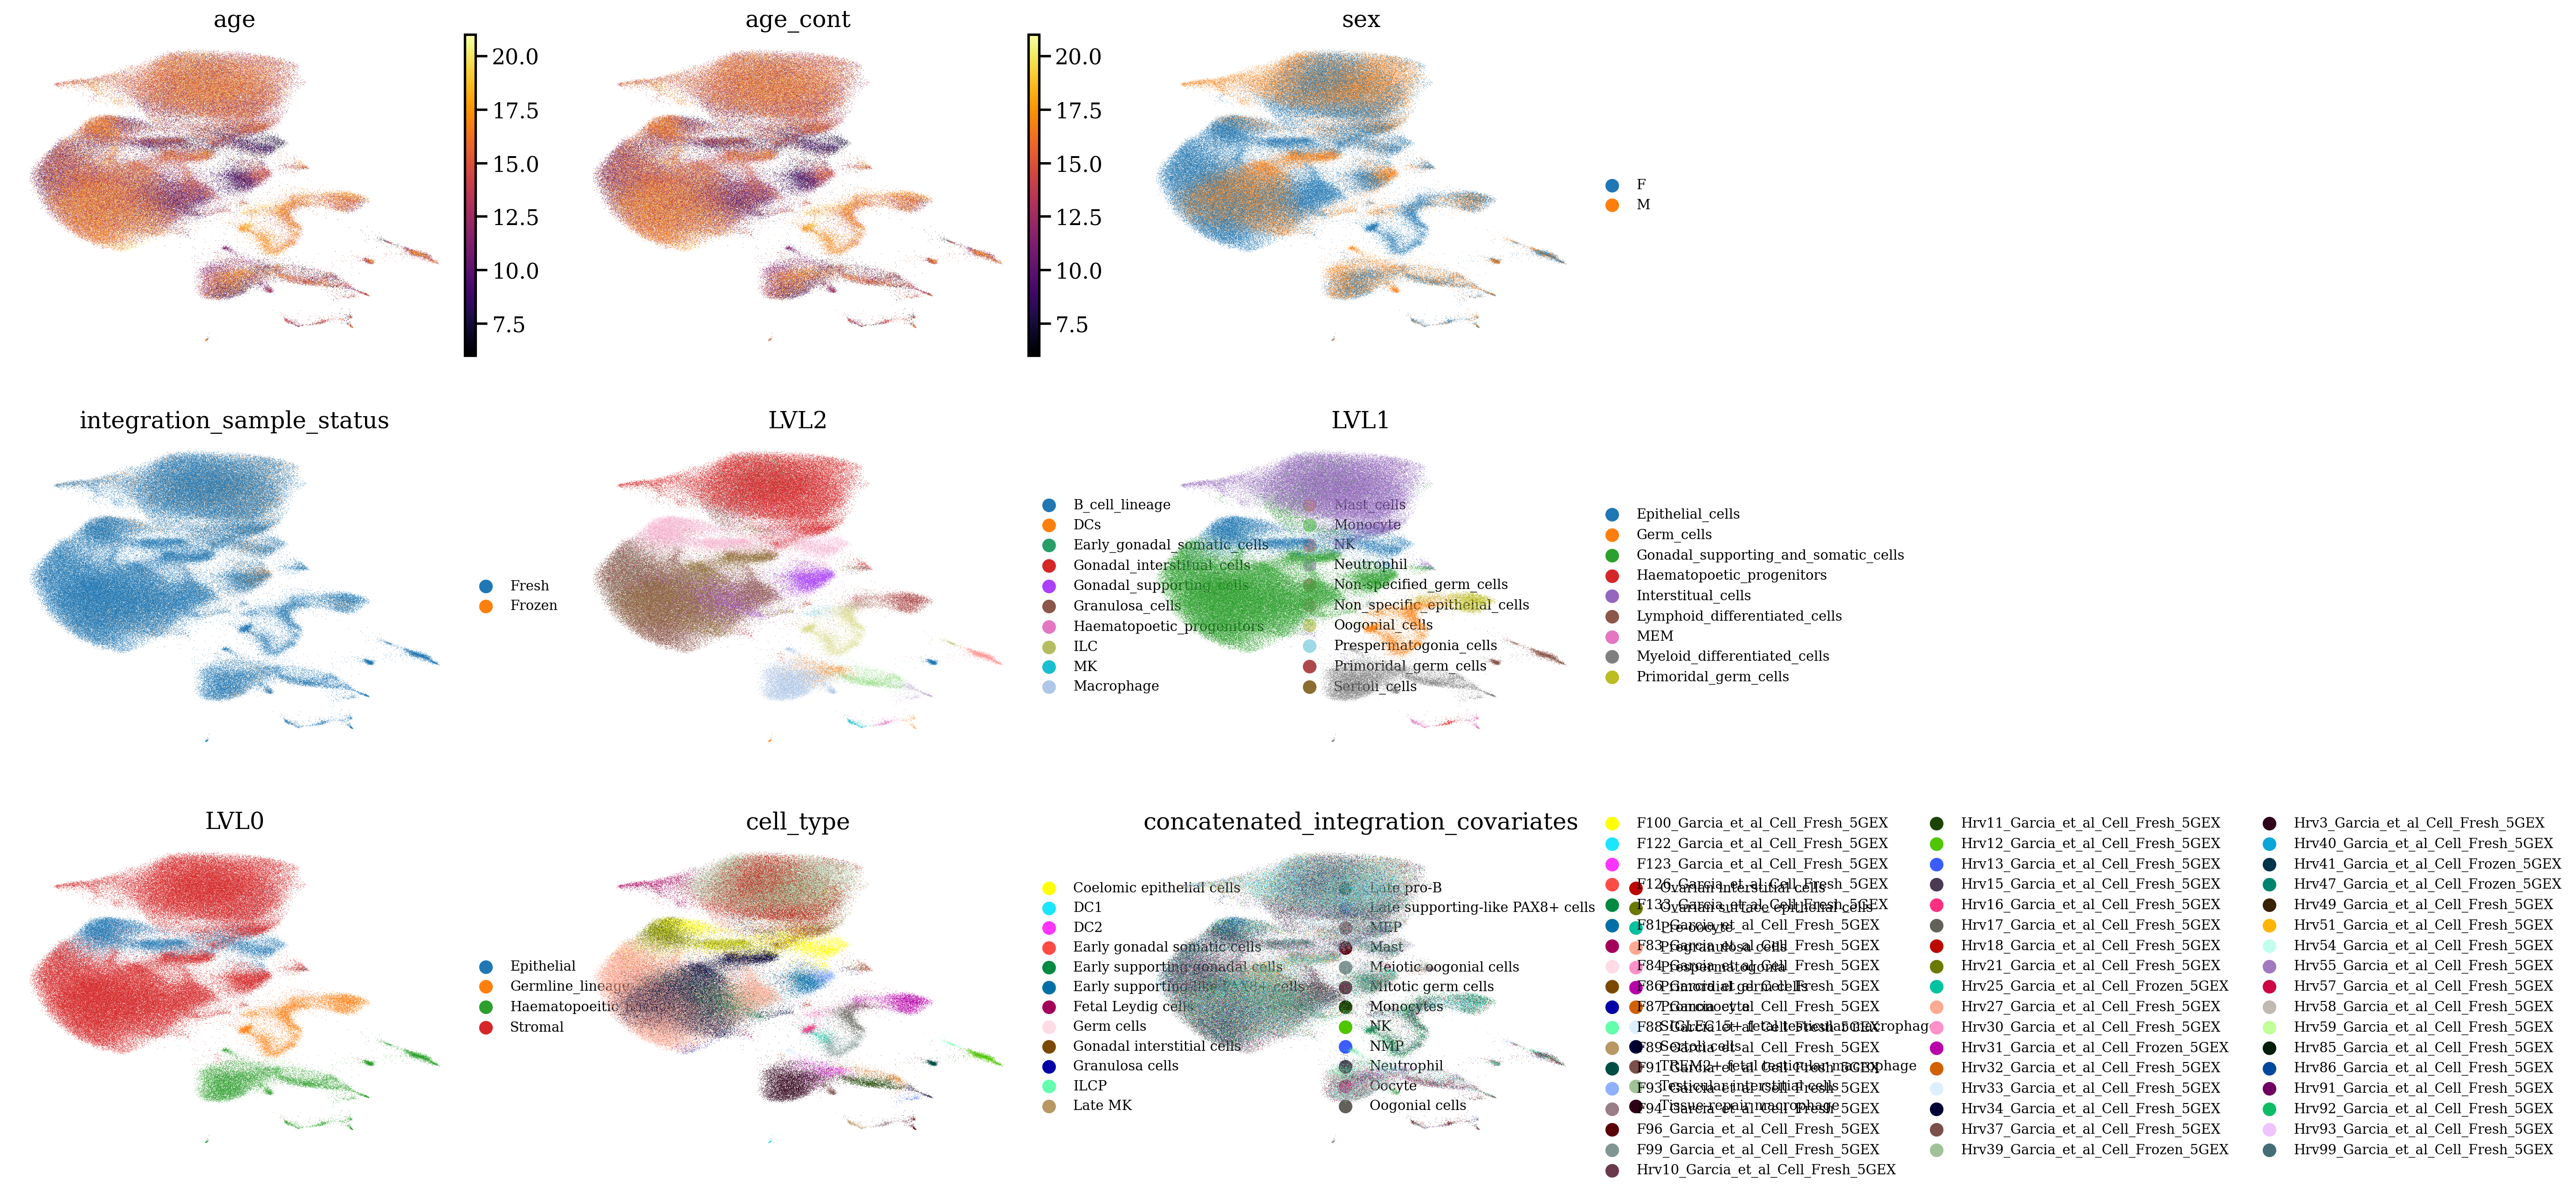

In [30]:
for k, v in dataset_handles.items():

    dataset_handles[k]["scvi_latent"].obs["age_cont"] = dataset_handles[k]["scvi_latent"].obs["age"].astype(float)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        sc.pl.umap(
            dataset_handles[k]["scvi_latent"],
            color=[
                "age",
                "age_cont",
                "sex",
                "integration_sample_status",
                "LVL2",
                "LVL1",
                "LVL0",
                "cell_type",
                "concatenated_integration_covariates",
            ],
            ncols=3,
            color_map="inferno",
            frameon=False,
            legend_fontsize="xx-small",
            show=False,
        )
        plt.suptitle(k, y=1.05)
        plt.show()